In [1]:
def is_interactive():
    import __main__ as main
    return not hasattr(main, '__file__')

import sys

if is_interactive():
    %matplotlib inline
    sys.path.append('../')

import numpy
from experiments.data import make_weak_true_partition
from wlc.WLweakener import computeM, weak_to_index, estimate_M
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from experiments.models import create_model, MyKerasClassifier
import inspect
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from matplotlib import cm

from experiments.visualizations import plot_heatmap
from experiments.visualizations import plot_confusion_matrix

plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams["figure.dpi"] = 100

cmap = cm.get_cmap('Accent')

from cycler import cycler
default_cycler = (cycler(color=['darkred', 'forestgreen', 'darkblue', 'violet', 'darkorange', 'saddlebrown']) +
                  cycler(linestyle=['-', '--', '-.', '-', '--', '-.']) + 
                  cycler(marker=['o', 'v', 'x', '+', '-', '.']) +
                  cycler(lw=[2, 1.8, 1.6, 1.4, 1.2, 1]))

plt.rc('lines', linewidth=1)
plt.rc('axes', prop_cycle=default_cycler)

if is_interactive():
    random_state = 7
else:
    random_state = int(sys.argv[1])
    
numpy.random.seed(random_state)

Using Theano backend.


# 1.a. Load data

The following data may contain weak, true labels or both ($S_w$, $S_t$ and $S_wt$ respectively).

- **PLEASE NOTE**: The current assumption is that the data is originally completly clean, or weak and weak+clean. But there is no current data with weak, weak+clean and clean. If at any point we have an example of that case we will need to rethinkg part of **Section 1**.

In [2]:
from sklearn.datasets import make_classification, make_blobs, load_digits
from experiments.data import load_webs

if is_interactive():
    dataset_name = 'separable'
else:
    dataset_name = sys.argv[2]
    
n_samples = 1000
n_features = 2
n_classes = 3
true_size = 0.2
classes = list(range(n_classes))
only_weak = ()
weak_and_true = ()
only_true = ()

if dataset_name == 'digits':
    true_size = 0.2
    X_t, y_t = load_digits(return_X_y=True)
    n_classes = 10
    true_size = 0.04
    classes = list(range(n_classes))
    n_samples = X_t.shape[0]
    n_features = X_t.shape[1]
    only_true = (X_t, y_t)
elif dataset_name == 'blobs':
    n_classes = 7
    classes = list(range(n_classes))
    n_features = 100
    n_samples = 10000
    true_size = 0.02
    centers = numpy.random.rand(n_classes, n_features)*2.0
    cluster_std = numpy.abs(numpy.random.randn(n_classes)*2.0)
    X_t, y_t = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers,
                      cluster_std=cluster_std, random_state=random_state)
    only_true = (X_t, y_t)
elif dataset_name == 'make_classification':
    n_classes = 12
    classes = list(range(n_classes))
    n_features = 100
    n_samples = 10000
    n_redundant = 0
    n_clusters_per_class = 1
    n_informative = n_features
    X_t, y_t = make_classification(n_samples=n_samples, n_features=n_features,
                               n_classes=n_classes, random_state=random_state,
                               n_redundant=n_redundant,
                               n_informative=n_informative,
                               n_clusters_per_class=n_clusters_per_class)
    only_true = (X_t, y_t)
elif dataset_name == 'separable':
    means = [[-1, -1],
             [-1,  1],
             [ 1,  1]]
    std = 1.0
    priors = numpy.array([.3, .3, .4])
    samples_per_class = (n_samples*priors).astype(int)
    X_t, y_t = make_blobs(n_samples=samples_per_class, n_features=n_features, centers=means,
                      cluster_std=std, random_state=random_state)
    only_true = (X_t, y_t)
    n_classes = 3
    n_samples = X_t.shape[0]
    n_features = X_t.shape[1]
elif dataset_name == 'non_separable':
    std = 2.0
    n_features = 5
    X_t, y_t =  make_blobs(n_samples=n_samples, n_features=n_features, centers=12,
                           cluster_std=std, random_state=random_state)
    y_t[y_t < 5] = 0
    y_t[y_t > 7] = 1
    y_t[y_t > 1] = 2
    only_true = (X_t, y_t)
    n_classes = 3
    n_samples = X_t.shape[0]
    n_features = X_t.shape[1]
elif dataset_name == 'webs':
    only_weak, weak_and_true, only_true, classes = load_webs(tfidf=True, standardize=True,
                                                categories=['blog', 'inmo', 'parking', 'b2c', 'no_b2c', 'Other'],
                                                random_state=random_state,
                                                folder='../data/')
    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
    
    n_classes = Y_wt.shape[1]
    n_features = X_w.shape[1]
    n_samples = X_wt.shape[0] + X_w.shape[0]
else:
    raise KeyError('Dataset {} not available'.format(dataset_name))

print('Number of features = {}'.format(n_features))
print('Number of classes = {}'.format(n_classes))
print('Class names = {}'.format(classes))

print('Samples with only weak labels = {}'.format(0 if not only_weak else only_weak[0].shape[0]))
print('Samples with weak and true labels = {}'.format(0 if not weak_and_true else weak_and_true[0].shape[0]))
print('Samples with only true labels = {}'.format(0 if not only_true else only_true[0].shape[0]))

Number of features = 2
Number of classes = 3
Class names = [0, 1, 2]
Samples with only weak labels = 0
Samples with weak and true labels = 0
Samples with only true labels = 1000


# 1.b. Create synthetic weak labels if required

If the dataset does not have weak labels we will generate a random mixing matrix and generate weak labels for some of the samples.

In [3]:
if not only_weak and not weak_and_true:
    if is_interactive():
        M_method = 'random_weak' # IPL, quasi_IPL, random_weak, random_noise, noisy, supervised
        M_alpha = 1.0 # Alpha = 1.0 No unsupervised in IPL
        M_beta = 0.5 # Beta = 0.0 No noise
    else:
        M_method = sys.argv[3]
        M_alpha = float(sys.argv[4])
        M_beta = float(sys.argv[5])

    if M_method != 'IPL':
        M_alpha = 1.0
    M = computeM(n_classes, method=M_method, alpha=M_alpha, beta=M_beta,
                 seed=random_state)

    print(numpy.round(M, decimals=3))
    
    only_weak, weak_and_true, only_true, classes = make_weak_true_partition(M, X_t, y_t,
                                                                            true_size=true_size,
                                                                            random_state=random_state)

    X_w, Z_w, z_w, Y_w, y_w = only_weak
    X_wt, Z_wt, z_wt, Y_wt, y_wt = weak_and_true
else:
    M_method = None
    M = estimate_M(Z_wt, Y_wt, range(n_classes), reg='Partial', Z_reg=Z_w)
    
print('Samples with only weak labels = {}'.format(0 if not only_weak else only_weak[0].shape[0]))
print('Samples with weak and true labels = {}'.format(0 if not weak_and_true else weak_and_true[0].shape[0]))
print('Samples with only true labels = {}'.format(0 if not only_true else only_true[0].shape[0]))

[[0.008 0.128 0.056]
 [0.073 0.161 0.568]
 [0.05  0.512 0.034]
 [0.05  0.112 0.102]
 [0.538 0.011 0.037]
 [0.091 0.035 0.057]
 [0.094 0.004 0.076]
 [0.096 0.038 0.07 ]]
Samples with only weak labels = 800
Samples with weak and true labels = 200
Samples with only true labels = 0


# 1.c. Show weak and true samples

In the following plots we show only the 2 features with most variance on every set

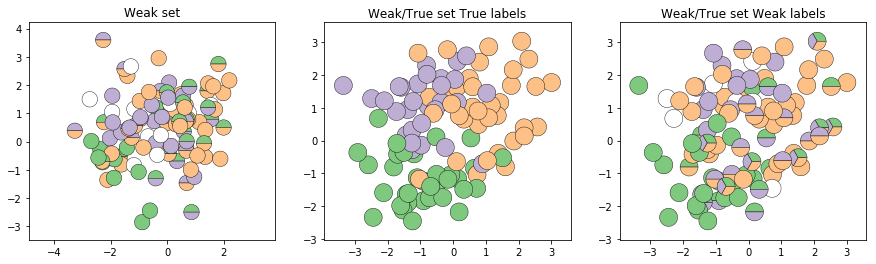

In [4]:
from experiments.visualizations import plot_multilabel_scatter

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1)
_ = plot_multilabel_scatter(X_w[:100, ], Z_w[:100], fig=fig,
                            ax=ax, title='Weak set', cmap=cmap)
ax = fig.add_subplot(1, 3, 2)
_ = plot_multilabel_scatter(X_wt[:100], Y_wt[:100], fig=fig,
                            ax=ax, title='Weak/True set True labels', cmap=cmap)
ax = fig.add_subplot(1, 3, 3)
_ = plot_multilabel_scatter(X_wt[:100], Z_wt[:100], fig=fig,
                            ax=ax, title='Weak/True set Weak labels', cmap=cmap)

# 1.d. Save true labels for testing

In [5]:
prop_test = 0.9
sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state,
                             train_size=(1. - prop_test),
                             test_size=prop_test)

val_indx, test_indx = next(sss.split(X_wt, y_wt))
print('Weak and true labels: Original partition size = {}'.format(len(z_wt)))
# test partition
X_wt_test, Z_wt_test, z_test = X_wt[test_indx], Z_wt[test_indx], z_wt[test_indx]
Y_wt_test, y_wt_test = Y_wt[test_indx], y_wt[test_indx]
# Validation partition
X_wt_val, Z_wt_val, z_wt_val = X_wt[val_indx], Z_wt[val_indx], z_wt[val_indx]
Y_wt_val, y_wt_val = Y_wt[val_indx], y_wt[val_indx]
print('Weak and true labels for validation partition size = {}'.format(len(y_wt_val)))
print('True labels for test partition size = {}'.format(len(y_wt_test)))

Weak and true labels: Original partition size = 200
Weak and true labels for validation partition size = 19
True labels for test partition size = 180


# 2.a. Train Scikit learn baselines

## 2.a.1. Upperbound if we have access to the full true labels

A Logistic Regression trained with all the real labels (819 samples)
Accuracy = 0.7555555555555555


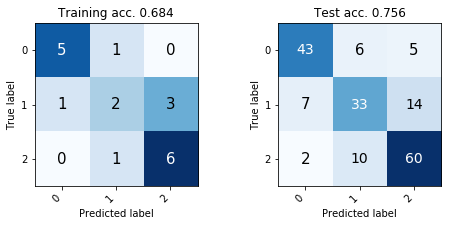

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

In [6]:
max_epochs = 2000

if y_w is not None:
    LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs, penalty='l2', C=0.01)
    LR.fit(numpy.concatenate((X_w, X_wt_val)), numpy.concatenate((y_w, y_wt_val)))
    print('A Logistic Regression trained with all the real labels ({} samples)'.format(y_w.shape[0] + y_wt_val.shape[0]))
    acc_upperbound = LR.score(X_wt_test, y_wt_test)
    print('Accuracy = {}'.format(acc_upperbound))

    fig = plt.figure(figsize=(8,3))
    clf_pred =  LR.predict(X_wt_val)
    cm = confusion_matrix(y_wt_val, clf_pred)
    acc = (y_wt_val == clf_pred).mean()
    ax = fig.add_subplot(1, 2, 1)
    _ = plot_confusion_matrix(cm, ax=ax, title='Training acc. {:.3}'.format(acc))

    clf_pred =  LR.predict(X_wt_test)
    cm = confusion_matrix(y_wt_test, clf_pred)
    acc = (y_wt_test == clf_pred).mean()
    ax = fig.add_subplot(1, 2, 2)
    _ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))

## 2.a.2. Lowerbound if we have access to a limited set of true labels

A Logistic Regression trained with only validation true labels (19 samples)
Accuracy = 0.6833333333333333


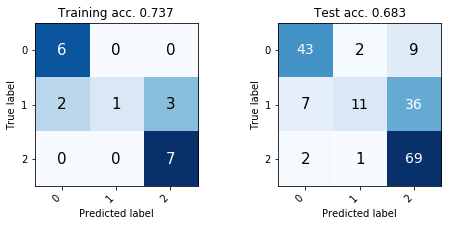

<Figure size 360x288 with 0 Axes>

<Figure size 360x288 with 0 Axes>

In [7]:
max_epochs = 2000

LR = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=max_epochs, penalty='l2', C=0.01)
LR.fit(X_wt_val, y_wt_val)
print('A Logistic Regression trained with only validation true labels ({} samples)'.format(y_wt_val.shape[0]))
acc_lowerbound = LR.score(X_wt_test, y_wt_test)
print('Accuracy = {}'.format(acc_lowerbound))

fig = plt.figure(figsize=(8,3))
clf_pred =  LR.predict(X_wt_val)
cm = confusion_matrix(y_wt_val, clf_pred)
acc = (y_wt_val == clf_pred).mean()
ax = fig.add_subplot(1, 2, 1)
_ = plot_confusion_matrix(cm, ax=ax, title='Training acc. {:.3}'.format(acc))

clf_pred =  LR.predict(X_wt_test)
cm = confusion_matrix(y_wt_test, clf_pred)
acc = (y_wt_test == clf_pred).mean()
ax = fig.add_subplot(1, 2, 2)
_ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))

# 2.b. Train Keras baselines


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras import regularizers

_EPSILON = K.epsilon()

def make_model(loss):
    model = Sequential() 
    model.add(Dense(n_classes, input_dim=n_features, activation='softmax',
                bias_initializer='zeros', 
                kernel_regularizer=regularizers.l2(1.0),
                kernel_initializer='glorot_normal'))
    model.compile(optimizer='adam', loss=loss,
                  metrics=['accuracy', 'mean_squared_error',
                           'categorical_crossentropy'])
    return model

from keras.callbacks import EarlyStopping

batch_size = 1024
patience = 500
early_stop_loss = 'val_acc'

early_stopping = EarlyStopping(monitor=early_stop_loss, min_delta=0, patience=patience, 
                               verbose=0, mode='auto', baseline=None,
                               restore_best_weights=True)

def plot_results(model, X_test, y_test, history):
    clf_proba_wt_test = model.predict_proba(X_test)
    clf_pred_wt_test = numpy.argmax(clf_proba_wt_test, axis=1)
    cm = confusion_matrix(y_test, clf_pred_wt_test)

    fig = plt.figure(figsize=(16, 3))
    n_fig = 5
    ax = fig.add_subplot(1, n_fig, 1)
    _ = ax.plot(history.history['loss'], label='Training loss')
    _ = ax.plot(history.history['val_loss'], label='Validation loss')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 2)
    _ = ax.plot(history.history['categorical_crossentropy'], label='Training CE')
    _ = ax.plot(history.history['val_categorical_crossentropy'], label='Validation CE')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 3)
    _ = ax.plot(history.history['mean_squared_error'], label='Training MSE')
    _ = ax.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 4)
    _ = ax.plot(history.history['acc'], label='Training acc')
    _ = ax.plot(history.history['val_acc'], label='Validation acc')
    ax.legend()
    ax = fig.add_subplot(1, n_fig, 5)
    acc = (y_test == clf_pred_wt_test).mean()
    _ = plot_confusion_matrix(cm, ax=ax, title='Test acc. {:.3}'.format(acc))

## 2.b.2. Upperbound if multiple true labels are available

A Keras Logistic Regression trained with all the real labels (819 samples)
Accuracy = 0.6555555555555556


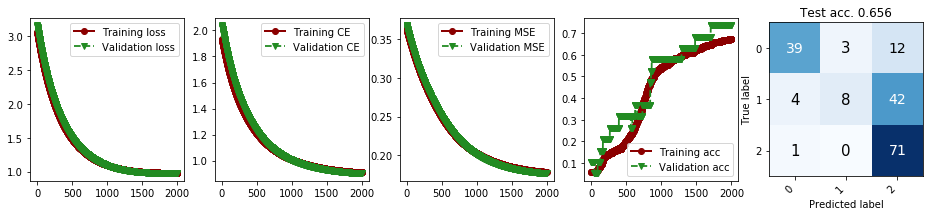

<Figure size 360x288 with 0 Axes>

In [9]:
if y_w is not None:
    numpy.random.seed(random_state)
    model = make_model('categorical_crossentropy')

    history = model.fit(numpy.concatenate((X_w, X_wt_val)), numpy.concatenate((Y_w, Y_wt_val)), 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size, shuffle=True)

    plot_results(model, X_wt_test, y_wt_test, history)

    print('A Keras Logistic Regression trained with all the real labels ({} samples)'.format(y_w.shape[0] + y_wt_val.shape[0]))
    acc_upperbound = (model.predict_proba(X_wt_test).argmax(axis=1) == y_wt_test).mean()
    print('Accuracy = {}'.format(acc_upperbound))

## 2.b.2. Lowerbound with a small amount of true labels

A Keras Logistic Regression trained with only validation true labels (19 samples)
Accuracy = 0.6666666666666666


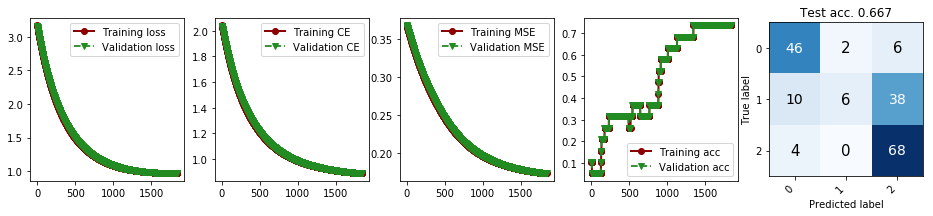

<Figure size 360x288 with 0 Axes>

In [10]:
numpy.random.seed(random_state)
model = make_model('categorical_crossentropy')

history = model.fit(X_wt_val, Y_wt_val, 
                    validation_data=(X_wt_val, Y_wt_val),
                    epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                    batch_size=batch_size, shuffle=True)

plot_results(model, X_wt_test, y_wt_test, history)

print('A Keras Logistic Regression trained with only validation true labels ({} samples)'.format(X_wt_val.shape[0]))
acc_lowerbound = (model.predict_proba(X_wt_test).argmax(axis=1) == y_wt_test).mean()
print('Accuracy = {}'.format(acc_lowerbound))

## 2.b.3. Training directly with different proportions of weak labels

In [11]:
list_weak_proportions = numpy.array([0.0, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 0.7, 1.0])
acc = {}

Number of weak samples = 800, Accuracy = 0.156

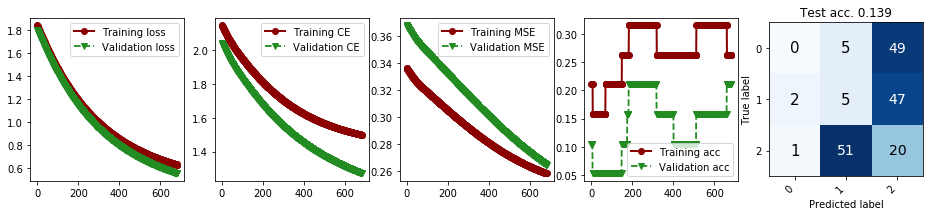

<Figure size 360x288 with 0 Axes>

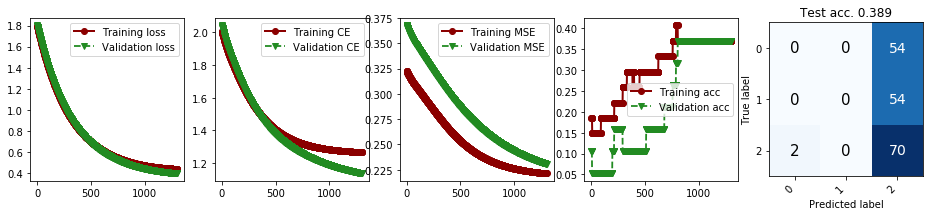

<Figure size 360x288 with 0 Axes>

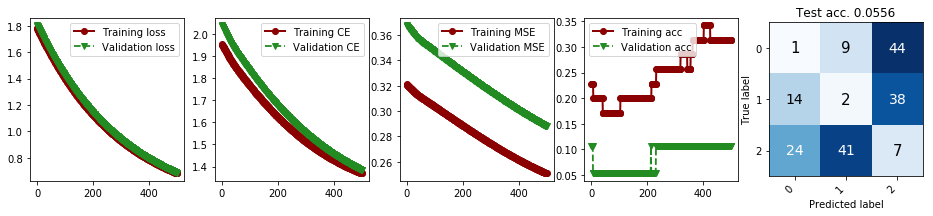

<Figure size 360x288 with 0 Axes>

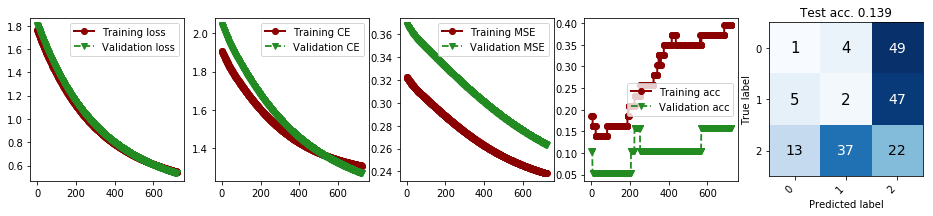

<Figure size 360x288 with 0 Axes>

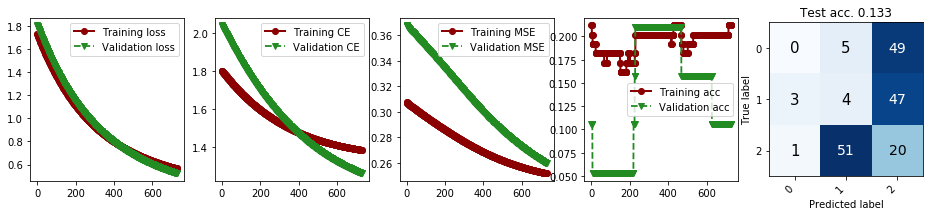

<Figure size 360x288 with 0 Axes>

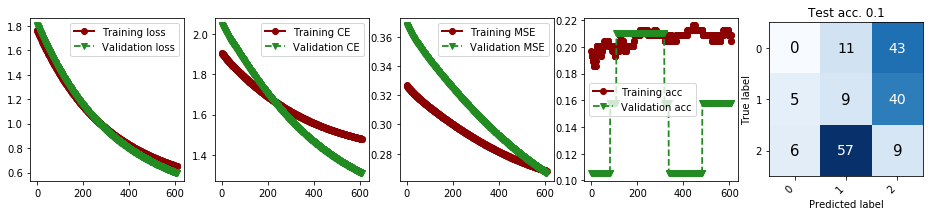

<Figure size 360x288 with 0 Axes>

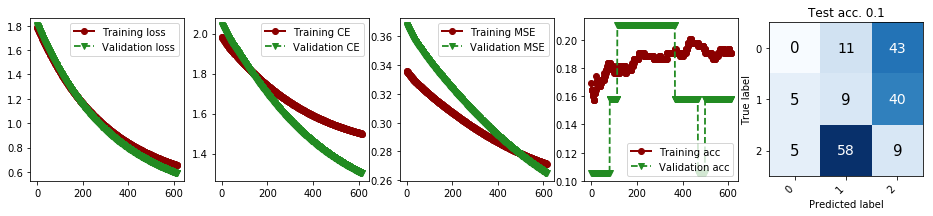

<Figure size 360x288 with 0 Axes>

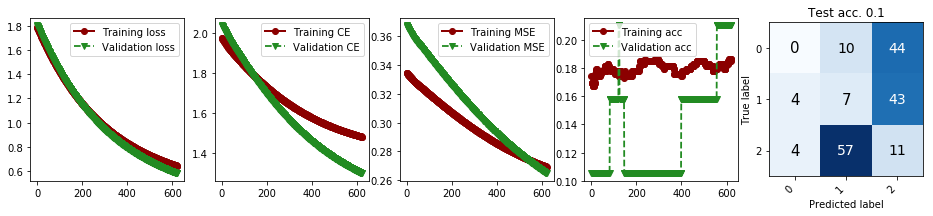

<Figure size 360x288 with 0 Axes>

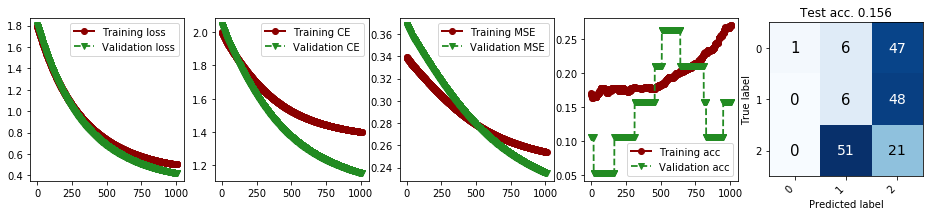

<Figure size 360x288 with 0 Axes>

In [12]:
def log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    out = -y_true*K.log(y_pred)
    return K.mean(out, axis=-1)

method = 'Weak'
acc[method] = numpy.zeros_like(list_weak_proportions)
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*X_w.shape[0])
    
    X_w_aux = numpy.concatenate((X_w[:last_index], X_wt_val), axis=0)
    Z_w_aux = numpy.concatenate((Z_w[:last_index], Z_wt_val), axis=0)
    numpy.random.seed(random_state)
    
    numpy.random.seed(random_state)
    model = make_model(log_loss)

    history = model.fit(X_w_aux, Z_w_aux,
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('\rNumber of weak samples = {}, Accuracy = {:.3f}'.format(last_index, acc[method][i]), end="", flush=True)
    
    plot_results(model, X_wt_test, y_wt_test, history)

# 3. Train EM

## 3.a. Learning mixing matrix M

../wlc/WLweakener.py:496: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  S[weak_list, :] = 1


q0 = 0.9768009768009768, q1 = 0.0231990231990232
M_0 shape = (8, 3)
[[0.071 0.143 0.067]
 [0.143 0.214 0.333]
 [0.071 0.214 0.067]
 [0.071 0.071 0.2  ]
 [0.214 0.071 0.067]
 [0.143 0.143 0.067]
 [0.214 0.071 0.067]
 [0.071 0.071 0.133]]
M_1 shape = (3, 3)
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
M_EM shape = (11, 3)
[[0.07  0.14  0.065]
 [0.14  0.209 0.326]
 [0.07  0.209 0.065]
 [0.07  0.07  0.195]
 [0.209 0.07  0.065]
 [0.14  0.14  0.065]
 [0.209 0.07  0.065]
 [0.07  0.07  0.13 ]
 [0.023 0.    0.   ]
 [0.    0.023 0.   ]
 [0.    0.    0.023]]
Z_wt
[[0 1 0]
 [0 0 1]
 [0 0 0]
 [1 1 0]
 [1 0 0]]
Y_wt
[[0 1 0]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]]
M_T shape = (11, 3)
[[0.007 0.125 0.054]
 [0.071 0.157 0.555]
 [0.049 0.5   0.033]
 [0.049 0.109 0.1  ]
 [0.526 0.011 0.036]
 [0.089 0.034 0.056]
 [0.091 0.004 0.074]
 [0.093 0.037 0.068]
 [0.023 0.    0.   ]
 [0.    0.023 0.   ]
 [0.    0.    0.023]]


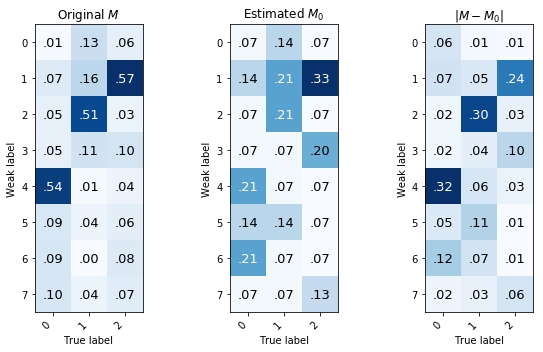

In [13]:
categories = range(n_classes)
# 1.a. Learn a mixing matrix using training with weak and true labels
M_0 = estimate_M(Z_wt_val, Y_wt_val, range(n_classes), reg='Partial', Z_reg=Z_w)
M_1 = computeM(c=n_classes, method='supervised')
q_0 = X_w.shape[0] / float(X_w.shape[0] + X_wt_val.shape[0])
q_1 = X_wt_val.shape[0] / float(X_w.shape[0] + X_wt_val.shape[0])
M_EM = numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)

print('q0 = {}, q1 = {}'.format(q_0, q_1))
print("M_0 shape = {}\n{}".format(M_0.shape, numpy.round(M_0, decimals=3)))
print("M_1 shape = {}\n{}".format(M_1.shape, numpy.round(M_1, decimals=3)))
print("M_EM shape = {}\n{}".format(M_EM.shape, numpy.round(M_EM, decimals=3)))
print("Z_wt\n{}".format(numpy.round(Z_wt_val[:5])))
print("Y_wt\n{}".format(numpy.round(Y_wt_val[:5])))

if M is not None:
    # 1.b. True mixing matrix
    M_T = numpy.concatenate((q_0*M, q_1*M_1), axis=0)
    print("M_T shape = {}\n{}".format(M_T.shape, numpy.round(M_T, decimals=3)))

    if n_classes < 5:
        # FIXME problem here when true M is square and estimated is not
        fig = plt.figure(figsize=(10, 5))
        for i, (title, m) in enumerate([(r'Original $M$', M),
                                        (r'Estimated $M_0$', M_0),
                                        (r'$|M - M_0|$', numpy.abs(M - M_0))]):
            ax = fig.add_subplot(1,3,i+1)
            fig = plot_heatmap(m, title=title, fig=fig, ax=ax,
                               xlabel='True label', ylabel='Weak label')

## 3.b. Train with true mixing matrix M if available

In [14]:
m = {}

def EM_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    Q = y_true * y_pred
    Z_em_train = Q / Q.sum(axis=-1, keepdims=True)
    out = -K.stop_gradient(Z_em_train)*K.log(y_pred)
    return K.mean(out, axis=-1)

Z_w_index [5 5 4 1 0]
Y_wt_val_index [1 2 1 0 0]
Mixing matrix M shape = (11, 3)
Number of weak samples = 800, Accuracy = 0.100

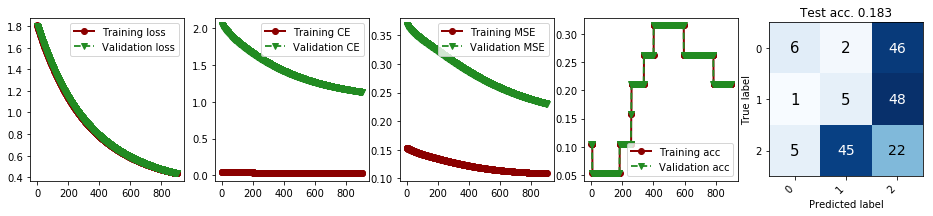

<Figure size 360x288 with 0 Axes>

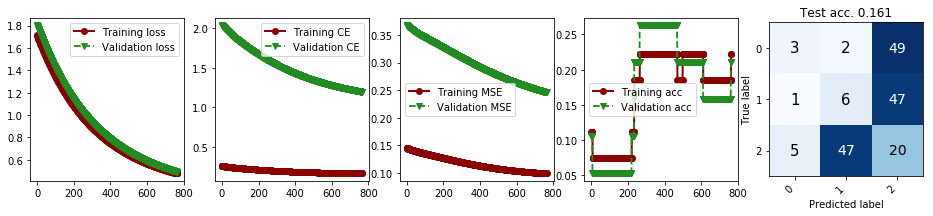

<Figure size 360x288 with 0 Axes>

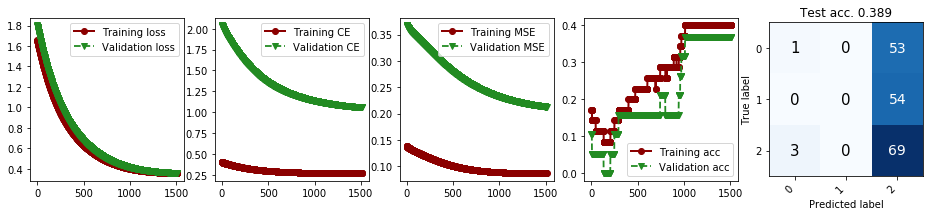

<Figure size 360x288 with 0 Axes>

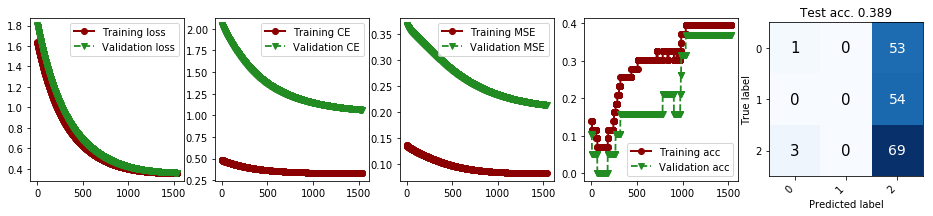

<Figure size 360x288 with 0 Axes>

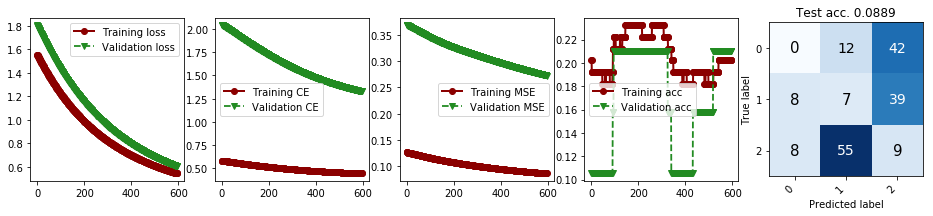

<Figure size 360x288 with 0 Axes>

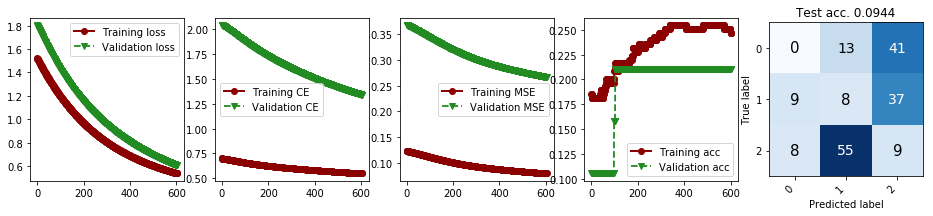

<Figure size 360x288 with 0 Axes>

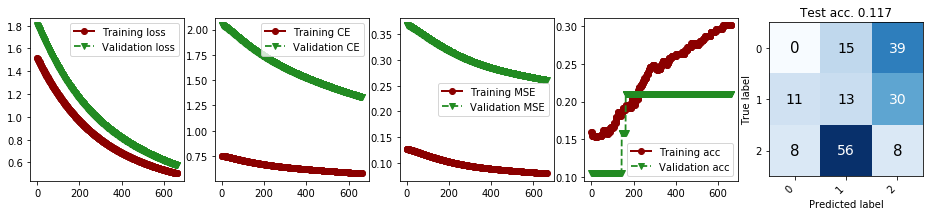

<Figure size 360x288 with 0 Axes>

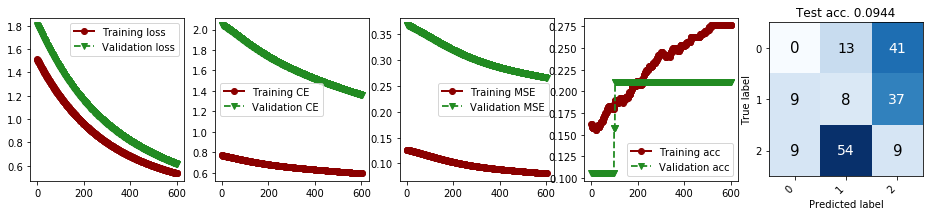

<Figure size 360x288 with 0 Axes>

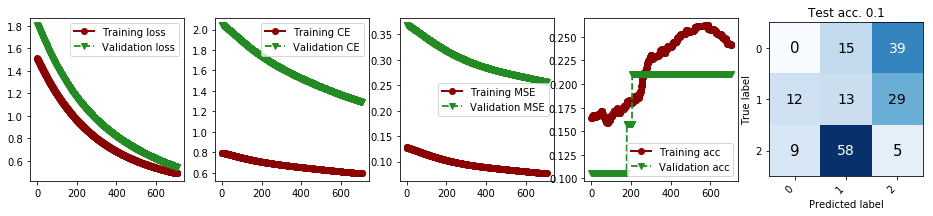

<Figure size 360x288 with 0 Axes>

In [15]:
Z_w_index = weak_to_index(Z_w, method='random_weak')
Y_wt_val_index = weak_to_index(Y_wt_val, method='supervised')
print("Z_w_index {}".format(Z_w_index[:5]))
print('Y_wt_val_index {}'.format(Y_wt_val_index[:5]))

method = 'EM M original'
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_T
print('Mixing matrix M shape = {}'.format(m[method].shape))
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_w.shape[0])
    
    Z_wt_train_index = numpy.concatenate((Z_w_index[:last_index], Y_wt_val_index + M_0.shape[0]))

    X_wt_train_aux = numpy.concatenate((X_w[:last_index], X_wt_val), axis=0)

    numpy.random.seed(random_state)
    model = make_model(EM_log_loss)

    # This fails with random noise (in that case the matrix M is not DxC but CxC)
    history = model.fit(X_wt_train_aux, m[method][Z_wt_train_index], 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('\rNumber of weak samples = {}, Accuracy = {:.3f}'.format(last_index, acc[method][i]), end="", flush=True)
    
    plot_results(model, X_wt_test, y_wt_test, history)

## 3.c. Train with estimated mixing matrix M_ME

Z_w_index [5 5 4 1 0]
Y_wt_val_index [1 2 1 0 0]
Mixing matrix M shape = (11, 3)
Number of weak samples = 800, Accuracy = 0.283

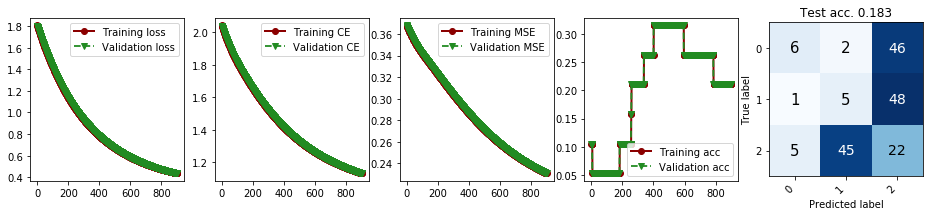

<Figure size 360x288 with 0 Axes>

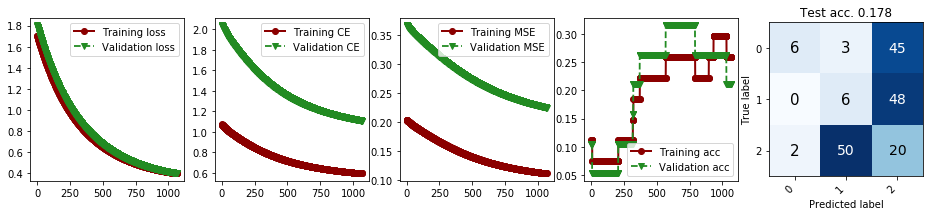

<Figure size 360x288 with 0 Axes>

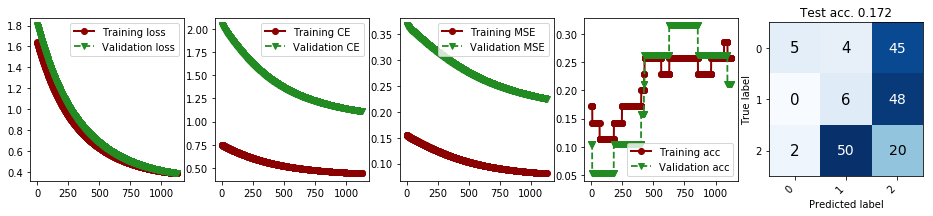

<Figure size 360x288 with 0 Axes>

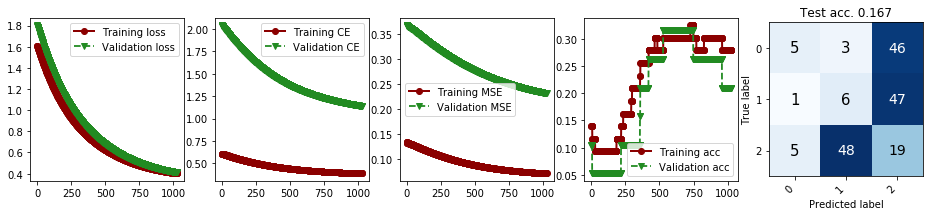

<Figure size 360x288 with 0 Axes>

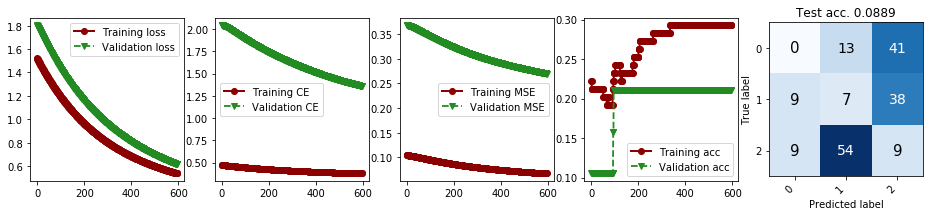

<Figure size 360x288 with 0 Axes>

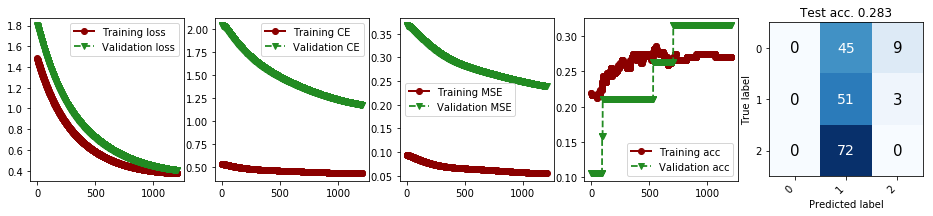

<Figure size 360x288 with 0 Axes>

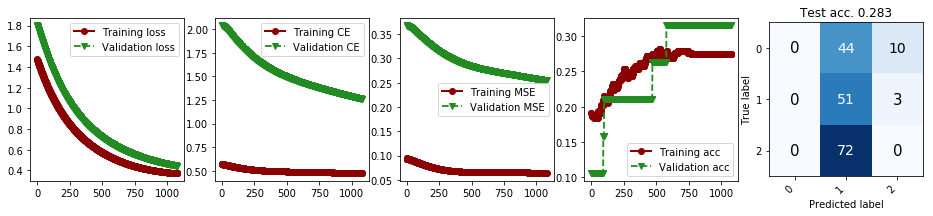

<Figure size 360x288 with 0 Axes>

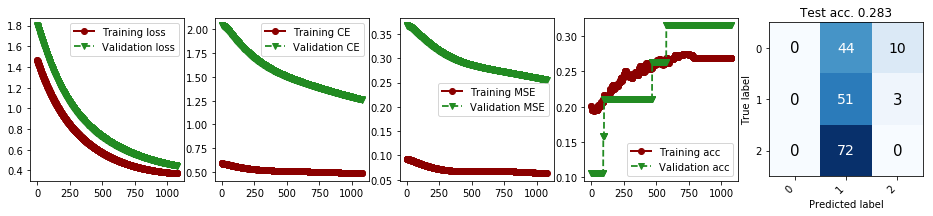

<Figure size 360x288 with 0 Axes>

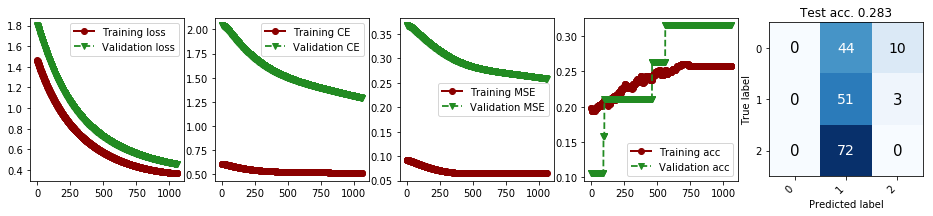

<Figure size 360x288 with 0 Axes>

In [16]:
Z_w_index = weak_to_index(Z_w, method='random_weak')
Y_wt_val_index = weak_to_index(Y_wt_val, method='supervised')
print("Z_w_index {}".format(Z_w_index[:5]))
print('Y_wt_val_index {}'.format(Y_wt_val_index[:5]))

method = 'EM M estimated'
acc[method] = numpy.zeros_like(list_weak_proportions)
m[method] = M_EM
print('Mixing matrix M shape = {}'.format(m[method].shape))
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*Z_w.shape[0])
    
    Z_wt_train_index = numpy.concatenate((Z_w_index[:last_index], Y_wt_val_index + M_0.shape[0]))

    X_wt_train_aux = numpy.concatenate((X_w[:last_index], X_wt_val), axis=0)

    # Change weights q for the actual sizes
    q_0 = last_index / float(last_index + X_wt_val.shape[0])
    q_1 = X_wt_val.shape[0] / float(last_index + X_wt_val.shape[0])
    m[method] = numpy.concatenate((q_0*M_0, q_1*M_1), axis=0)

    numpy.random.seed(random_state)
    model = make_model(EM_log_loss)

    # This fails with random noise (in that case the matrix M is not DxC but CxC)
    history = model.fit(X_wt_train_aux, m[method][Z_wt_train_index], 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('\rNumber of weak samples = {}, Accuracy = {:.3f}'.format(last_index, acc[method][i]), end="", flush=True)
    
    plot_results(model, X_wt_test, y_wt_test, history)

## 4. Baseline Optimistic Superset Learning



Number of weak samples = 800, Accuracy = 0.083

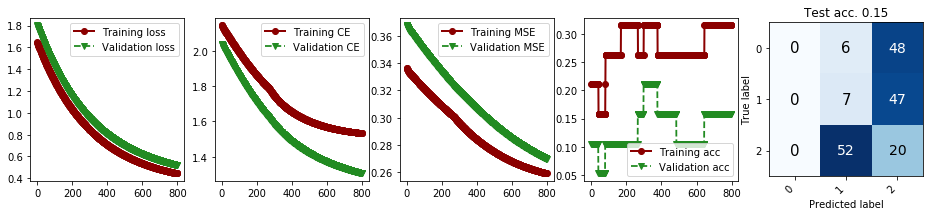

<Figure size 360x288 with 0 Axes>

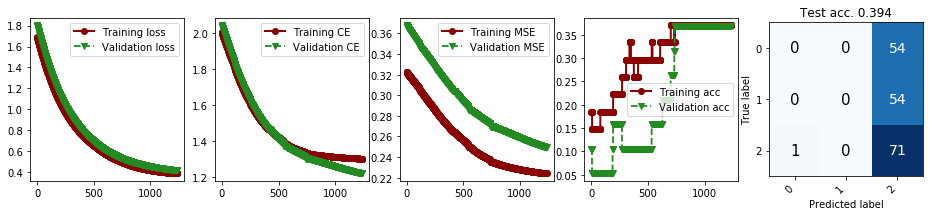

<Figure size 360x288 with 0 Axes>

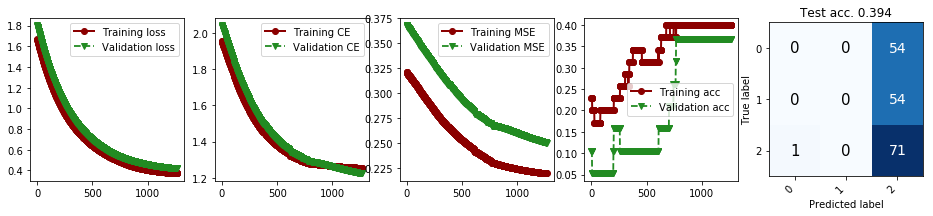

<Figure size 360x288 with 0 Axes>

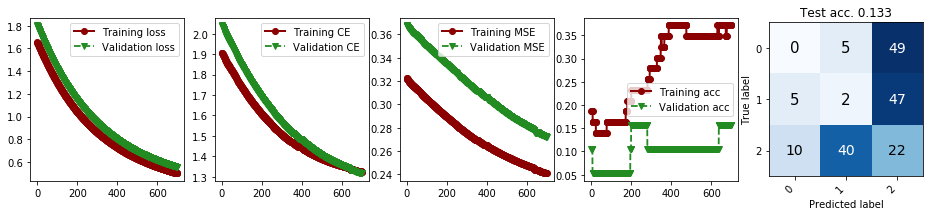

<Figure size 360x288 with 0 Axes>

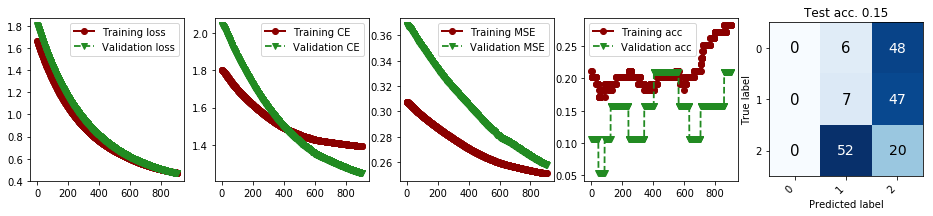

<Figure size 360x288 with 0 Axes>

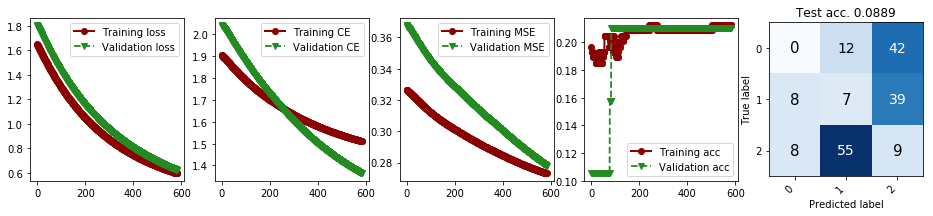

<Figure size 360x288 with 0 Axes>

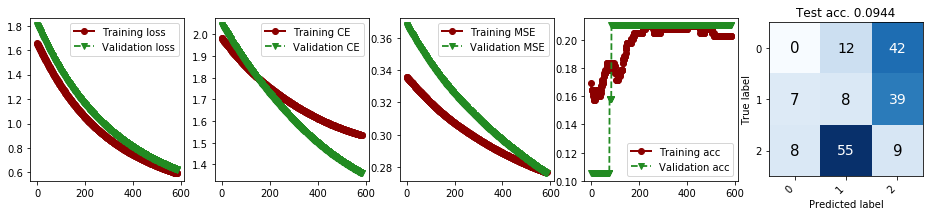

<Figure size 360x288 with 0 Axes>

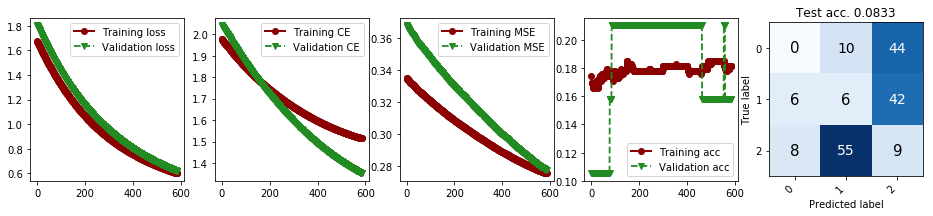

<Figure size 360x288 with 0 Axes>

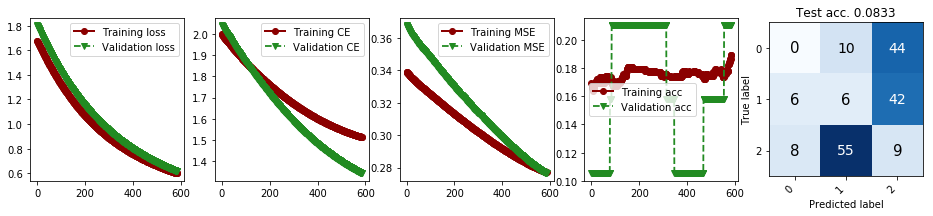

<Figure size 360x288 with 0 Axes>

In [17]:
def OSL_log_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, _EPSILON, 1.0-_EPSILON)
    O = y_true * y_pred
    S = K.cast(K.equal(O,
                       O.max(axis=-1).repeat(O.shape[-1]
                                            ).reshape((-1, O.shape[-1]))),
               'float32')
    out = -K.stop_gradient(S) * K.log(y_pred)
    return K.mean(out, axis=-1)

method = 'OSL'

acc[method] = numpy.zeros_like(list_weak_proportions)
for i, weak_proportion in enumerate(list_weak_proportions):
    last_index = int(weak_proportion*X_w.shape[0])

    X_wt_train = numpy.concatenate((X_w[:last_index], X_wt_val), axis=0)
    Z_wt_train = numpy.concatenate((Z_w[:last_index], Z_wt_val), axis=0)

    numpy.random.seed(random_state)
    model = make_model(OSL_log_loss)

    # This fails with random noise (in that case the matrix M is not DxC but CxC)
    history = model.fit(X_wt_train, Z_wt_train, 
                        validation_data=(X_wt_val, Y_wt_val),
                        epochs=max_epochs, verbose=0, callbacks=[early_stopping],
                        batch_size=batch_size)
    # 5. Evaluate the model in the test set with true labels
    y_pred = model.predict(X_wt_test).argmax(axis=1)
    acc[method][i] = (y_pred == y_wt_test).mean()
    print('\rNumber of weak samples = {}, Accuracy = {:.3f}'.format(last_index, acc[method][i]), end="", flush=True)
    
    plot_results(model, X_wt_test, y_wt_test, history)

# 5. Plot results

Acc. Upperbound = 0.6555555555555556
Acc. Weak
[0.13888889 0.38888889 0.05555556 0.13888889 0.13333333 0.1
 0.1        0.1        0.15555556]
Acc. EM M original
[0.18333333 0.16111111 0.38888889 0.38888889 0.08888889 0.09444444
 0.11666667 0.09444444 0.1       ]
Acc. EM M estimated
[0.18333333 0.17777778 0.17222222 0.16666667 0.08888889 0.28333333
 0.28333333 0.28333333 0.28333333]
Acc. OSL
[0.15       0.39444444 0.39444444 0.13333333 0.15       0.08888889
 0.09444444 0.08333333 0.08333333]
Acc. Lowerbound = 0.6666666666666666


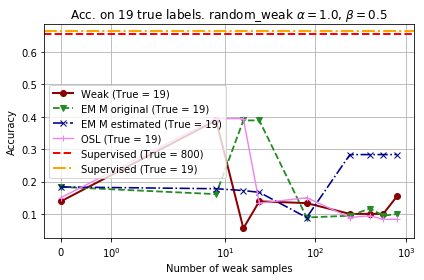

In [18]:
if M is not None:
    print('Acc. Upperbound = {}'.format(acc_upperbound))
for key, value in acc.items():
    print('Acc. {}\n{}'.format(key, value))
print('Acc. Lowerbound = {}'.format(acc_lowerbound))

fig = plt.figure()
ax = fig.add_subplot(111)
if M_method is not None:
    M_text = r'{} $\alpha={:0.1f}$, $\beta={:0.1f}$'.format(M_method, M_alpha, M_beta)
else:
    M_text = ''
ax.set_title(r'Acc. on {} true labels. {}'.format(X_wt_val.shape[0], M_text))
for key, value in acc.items():
    ax.plot(list_weak_proportions*Z_w.shape[0], value, label='{} (True = {})'.format(key, Y_wt_val.shape[0]))
#ax.plot(list_weak_proportions*Z_t_index.shape[0], acc_EM, 'v-', color='blue', label='EM weak + {} true labels'.format(Z_v.shape[0]))
#ax.plot(list_weak_proportions*Z_t_index.shape[0], acc_weak, 'x-', color='magenta', label='Weak + {} true labels'.format(Z_v.shape[0]))
#ax.plot(list_weak_proportions*Z_t_index.shape[0], acc_OSL, '+-', color='green', label='OSL Weak + {} true labels'.format(Z_v.shape[0]))
if y_w is not None:
    ax.axhline(y=acc_upperbound, color='red', lw=2,linestyle='--', label='Supervised (True = {})'.format(X_w.shape[0]))
ax.axhline(y=acc_lowerbound, color='orange', lw=2, linestyle='-.', label='Supervised (True = {})'.format(Z_wt_val.shape[0]))
ax.set_xlabel('Number of weak samples')
ax.set_ylabel('Accuracy')
ax.set_xscale("symlog")
ax.legend(loc=0, fancybox=True, framealpha=0.8)
ax.grid()
fig.tight_layout()
if M_method is not None:
    M_text = '_{}_a{:02.0f}_b{:02.0f}'.format(M_method, M_alpha, M_beta)
else:
    M_text = ''
fig.savefig('full_vs_em_{}{}.svg'.format(dataset_name, M_text))

In [19]:
import pandas

df_experiment = pandas.DataFrame.from_dict(
    dict(random_state=random_state,
         dataset_name=dataset_name,
         n_samples=n_samples,
         n_features=n_features,
         M_method=M_method,
         M_alpha=M_alpha,
         M_beta=M_beta,
         weak_proportions=list_weak_proportions*Z_w.shape[0],
         acc_methods=acc,
         acc_upperbound=acc_upperbound,
         acc_lowerbound=acc_lowerbound,
        ), orient='index')
print(df_experiment)
df_experiment.to_json('_'.join([str(i) for i in (random_state, dataset_name, n_samples, M_method)]) + '.json')

                                                                  0
random_state                                                      7
dataset_name                                              separable
n_samples                                                      1000
n_features                                                        2
M_method                                                random_weak
M_alpha                                                           1
M_beta                                                          0.5
weak_proportions  [0.0, 8.0, 16.0, 24.0, 80.0, 240.0, 400.0, 560...
acc_methods       {'Weak': [0.1388888888888889, 0.38888888888888...
acc_upperbound                                             0.655556
acc_lowerbound                                             0.666667


In [21]:
pandas.read_json('_'.join([str(i) for i in (random_state, dataset_name, n_samples, M_method)]) + '.json')

,0
M_alpha,1
M_beta,0.5
M_method,random_weak
acc_lowerbound,0.666667
acc_methods,"{'Weak': [0.1388888889, 0.3888888889, 0.055555..."
acc_upperbound,0.655556
dataset_name,separable
n_features,2
n_samples,1000
random_state,7
